In [ ]:
# Install txtai and elasticsearch python client
!pip install git+https://github.com/neuml/txtai elasticsearch

# Download and extract elasticsearch
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.8.1-linux-x86_64.tar.gz
!tar -xzf elasticsearch-7.8.1-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.8.1

In [ ]:
#Hosting ElasticSearch sever
import os
from subprocess import Popen, PIPE, STDOUT

# Start and wait for server
server = Popen(['elasticsearch-7.8.1/bin/elasticsearch'], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
from elasticsearch import Elasticsearch
es = Elasticsearch(hosts=["http://localhost:9200"], timeout=60, retry_on_timeout=True)
es.indices.create(index="environment", ignore=400)

In [ ]:
lines=[]
with open('../input/combined/tvnews_corpus.tsv', 'r', errors='replace') as f:
    lines = f.readlines()

In [ ]:
# Building Elastic Search Index
from tqdm import tqdm
import csv
counter = 1
finalMapping = dict()

for dirname,_,filenames in os.walk('../input/environmental-news-nlp-dataset/TelevisionNews'):
    for filename in tqdm(filenames, "progress"):
        path = os.path.join(dirname, filename)
        with open(path, 'r', errors='replace') as file: 
            reader = csv.reader(file)
            dictForRow = dict()
            rowNum = 0
            for row in reader:
                if(rowNum!=0):
                    dictForRow['snippet'] = row[6]
                    strBuilder = str(filename) + "#" + str(rowNum)
                    finalMapping[counter] = strBuilder
                    es.index(index="environment", doc_type="env", id=strBuilder, body=dictForRow)
                    counter += 1
                rowNum+=1

In [ ]:
#Testing a Search
res = es.search(index="environment", body={"from":0, "size":10000, "min_score":0, "query":{"match":{"snippet":"Global warming is a hoax"}}})

In [25]:
#Installing dependicies for SearchAPI
!pip install pywsd

  Using cached pywsd-1.2.4.tar.gz (26.8 MB)
  Using cached wn-0.0.23.tar.gz (31.6 MB)
  Created wheel for pywsd: filename=pywsd-1.2.4-py3-none-any.whl size=26940452 sha256=172c61f259603428804137f67f7fc1ec6a8e0a8058a3023a3f769d6f3ac907c1
  Stored in directory: /root/.cache/pip/wheels/56/67/c0/6e6fa8456d1374b393328368316c3b33844cb4043bd225bc66
  Created wheel for wn: filename=wn-0.0.23-py3-none-any.whl size=31792943 sha256=da53e8abc972ff5ebf98167392be10a396f6bafbed7d9b7c66869452283ab94a
  Stored in directory: /root/.cache/pip/wheels/ec/47/17/409766c99dd470f34c512000b90b83f34747c2c975769654d7
Successfully built pywsd wn


In [26]:
#Search API
import pickle
import operator
import time
from pywsd.utils import lemmatize_sentence
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(v1,v2):
    return dot(v1, v2)/(norm(v1)*norm(v2))

# The inverted index file contents are loaded into memory
# All queries will be analyzed with this, so it is fine to preload
with open("../input/indexing/inv_index_v2","rb") as f:
    posting_list = pickle.load(f)
    file_dict = pickle.load(f)
    vocab = pickle.load(f)

# The actual data is also loaded to be display the search results
fileobj = open('../input/combined/tvnews_corpus.tsv','r', errors='ignore')
lines = fileobj.readlines()
fileobj.close()

def searchAPI(searchterm):
    query = searchterm
    query_tokens = lemmatize_sentence(query) # lemmatize tokens to use as in vocabulary
    query_vector = []
    query_tf = {}
    total_query_vocab = 0
    for tok in query_tokens:
        try:
            indexvalue = vocab.index(tok)
            query_vector.append(indexvalue)
            query_tf[indexvalue] = 1 + query_tf.get(indexvalue,0)
            total_query_vocab += 1
        except ValueError: # Token doesnt exist in vocab - ignored
            deadcode='a'


    start_time = time.time() # Timer starts

    # First we obtain the list of all possible documents we actually need to search
    # This is a union of the docs in each query term's posting list
    # Not an intersection because we use cosine similarity and not boolean retrieval
    possible_docs = set()
    query_tf_vector = []

    for q in query_vector:
        possible_docs = possible_docs.union(posting_list[q].keys())
        query_tf_vector.append(query_tf[q]/total_query_vocab)
        # We also generate a TDF vector for the query. Does not make sense to scale with IDF

    # Run through each doc and generate the vector corresponding to the query terms
    # Compute the cosine similarities of it vs the TF vector of the query
    # Ties are broken by the magnitude of the vector - note that this is obtained by only considering the query terms
    # Plus these query term weights were scaled with relative TF, so a higher magnitude means the terms were more important
    doc_scores = {}
    for doc in possible_docs:
        doc_vector = []
        for q in query_vector:
            doc_vector.append(posting_list[q].get(doc,0))
        doc_scores[doc] = (cosine_similarity(doc_vector,query_tf_vector), norm(doc_vector))

    # Results are sorted
    sorted_results = sorted(doc_scores.items(), key=operator.itemgetter(1), reverse=True)

    end_time = time.time() # Timer ends as search portion is complete
    search_time = end_time - start_time

    ct = 1
    #print("-------------- SEARCH RESULTS --------------")
    results={}
    results['Details']=[]
    results['Documents']=[]
    for i in sorted_results:
        fname, rownum = file_dict[i[0]].split(' ')
        rownum = int(rownum[3:])
        search_res = lines[i[0]]
        search_res = search_res.split('\t')[2]
        answer=fname+'#'+str(rownum+1)
        results['Documents'].append(answer.split('\\')[-1])
        results['Details'].append({'Name': fname+'#'+str(rownum+1), 'Score': i[1], 'Results': search_res})
        ct += 1
    results['Time']=end_time-start_time
    return results

Warming up PyWSD (takes ~10 secs)... took 9.918627500534058 secs.


In [27]:
#Helper functions forRelevant Documents
def retrivetopkelastic(hits):
    topk=[]
    for i in range(0,len(hits)):
        topk.append(hits[i]['_id'])
    return topk

def retrievaAllElastic(line):
    total=[]
    data = es.search(index="environment",scroll='2m', body={"from":0, "size": 10000, "min_score":0, "query":{"match":{"snippet":line}}})
    sid = data['_scroll_id']
    scroll_size = len(data['hits']['hits'])
    while scroll_size > 0:
        scroll_size = len(data['hits']['hits'])
        total+=[id['_id'] for id in data['hits']['hits']]
        data = es.scroll(scroll_id=sid, scroll='2m')
        sid = data['_scroll_id']
    return total

In [28]:
#Run OurModel and ElasticSearch for TestCases
import time

testcasefile="../input/samplequeries/sample_queries.txt"
inputfile= open(testcasefile,"r")
timelist1=[]
timelist2=[]

retrieved=[]
relevant=[]

for line in tqdm((inputfile.read()).split('\n'), "progress"):
    
    #SearchAPI
    results = searchAPI(line)
    timelist1.append(results['Time'])
    retrieved.append(results['Documents'])
    
    #Elastic Search
    tic=time.time()
    relevant.append(retrievaAllElastic(line))
    toc=time.time()
    timelist2.append(toc-tic)

progress: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


In [ ]:
#Storing Results
with open("resultsfinalv1","wb") as f:
    pickle.dump(retrieved,f)
    pickle.dump(relevant, f)
    pickle.dump(timelist1,f)
    pickle.dump(timelist2,f)

In [30]:
#Retrieving Results
#Also Available At https://drive.google.com/file/d/19wQG2DA6o_ArZRlsK3AFeZEwGsqkn4xX/view?usp=sharing
import pickle
with open("../input/resultsfinal/resultsfinalv1","rb") as f:
    retrieved = pickle.load(f)
    relevant = pickle.load(f)
    timelist1 = pickle.load(f)
    timelist2 = pickle.load(f)

In [31]:
#Calculating Percentage Change in Time between OurModel and ElasticSearch
perchange = []
for a, b in zip(timelist1, timelist2):
    perchange.append(100 * (a - b) / b)

<Figure size 800x600 with 0 Axes>

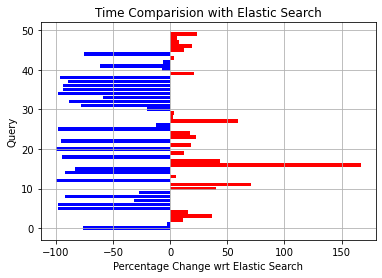

Average Time Taken
Our Model 0.7344591808319092 s
Elastic Search 1.6653825616836548 s


In [155]:
#Plotting Percentage Time Change and Average Time Taken
import numpy as np
import random
from matplotlib import pyplot as plt

y = perchange

N = len(y)
x = np.arange(50)
width = 1 / 1.1
plt.figure(figsize=(8, 6), dpi=100)

fig, ax = plt.subplots(1, 1)
ax.grid(zorder=0)
positives = ['r'if(i>0) else'b' for i in y] 
bars = ax.barh(x, y, width, color=positives)


plt.title('Time Comparision with Elastic Search')
plt.ylabel('Query')
plt.xlabel('Percentage Change wrt Elastic Search')
plt.show()

print("Average Time Taken")
print("Our Model", sum(timelist1)/len(timelist1),"s")
print("Elastic Search", sum(timelist2)/len(timelist2),"s")

In [122]:
#Calculating Precision and Recall for Values of k i.e. top k results
from tqdm import tqdm
precisions = []
recalls = []

    
for k in tqdm(range(1,93000,50), 'progress'):
    precisionnum = 0
    precisionden = 0
    intermprecision = []
    intermrecall = []
    for i in range(50):
        precisionnum=len(set(retrieved[i][:k]).intersection(relevant[i][:int(0.2*len(relevant[i]))]))
        precisionden=len(set(retrieved[i][:k]))
        intermprecision.append(precisionnum/precisionden)
    precisions.append(sum(intermprecision)/50)
    recallnum = 0
    recallden = 0
    intermrecalls = []
    for i in range(50):
        recallnum=len(set(retrieved[i][:k]).intersection(relevant[i][:int(0.2*len(relevant[i]))]))
        recallden=len(set(relevant[i][:int(0.2*len(relevant[i]))]))
        intermrecalls.append(recallnum/recallden)
    recalls.append(sum(intermrecalls)/50)

progress: 100%|██████████| 1860/1860 [09:17<00:00,  3.34it/s]


In [152]:
# Top k Intersection
from tqdm import tqdm
topkintersection = []
for k in tqdm(list(range(0,105,5))[1:], 'progress'):
    intermk=[]
    for i in range(50):
        knum=len(set(retrieved[i][:k]).intersection(relevant[i][:k]))
        intermk.append(knum/k)
    topkintersection.append(sum(intermk)/50)
#Average k intersection value
print("Average k Interesection:", sum(topkintersection)/len(topkintersection))

progress: 100%|██████████| 20/20 [00:00<00:00, 1503.01it/s]

Average k Interesection: 0.33749294998173485


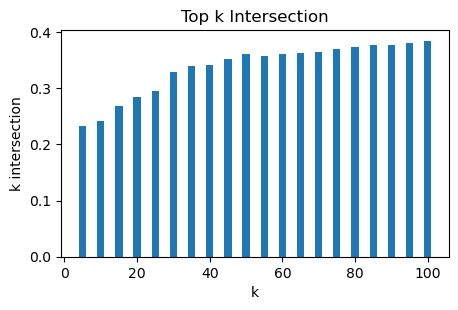

In [153]:
#Plotting Top k Intersection
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

width=2
plt.figure(figsize=(5, 3), dpi=100)
plt.bar(list(range(0,105,5))[1:], topkintersection, width, label='Our Model')
plt.xlabel("k")
plt.ylabel('k intersection')
plt.title('Top k Intersection')
plt.show()

In [125]:
#Interpolating
indices = [0.0, 0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
recallprec = [(recalls[i], precisions[i]) for i in range(len(recalls))]

#Calculating Interpolated Precison for Recall Levels
recallprec.sort()
values=[]
for ind in tqdm(indices, 'Progress'):
    maxim=-1000
    for i in recallprec:
        if(i[0]>ind and i[1]>maxim):
            maxim=i[1]
    if(maxim!=-1000):
        values.append(maxim)
    else:
        values.append(values[len(values)-1])

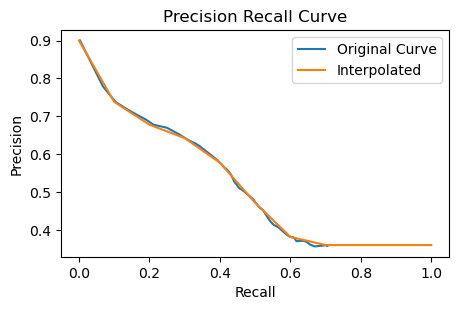

In [132]:
#Plotting PR Curve and Interpolated PR Curve
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
%matplotlib inline

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

plt.figure(figsize=(5, 3), dpi=100)
plt.plot(recalls, precisions, label = 'Original Curve')
plt.plot(indices,values, label = 'Interpolated')

plt.xlabel("Recall")
plt.title('Precision Recall Curve')
plt.ylabel("Precision")
plt.legend()
plt.show()


In [158]:
#MAP Calculation
print("Recall\tInterp. Precision")
for i in range(len(indices)):
    print(indices[i],'\t', values[i])
print("MEAN AVERAGE PRECISION:", sum(values)/len(values))

Recall	Interp. Precision
0.0 	 0.9
0.1 	 0.7383457730388423
0.2 	 0.6782098951156733
0.3 	 0.6428997046492947
0.4 	 0.5781129958398119
0.5 	 0.4727007688714538
0.6 	 0.3826434434178654
0.7 	 0.36115794878981733
0.8 	 0.36115794878981733
0.9 	 0.36115794878981733
1.0 	 0.36115794878981733
MEAN AVERAGE PRECISION: 0.530685852372019
